### LSTM Autoencoder Classifier

- 資料集: https://arxiv.org/abs/1809.10717

#### 一、匯入模組

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, roc_curve

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

Using TensorFlow backend.


#### 二、資料預處理(Data preprocessing)

1.匯入資料

In [2]:
df = pd.read_excel("processminer-rare-event-mts.xlsx")

2.移動資料

- 將資料含有 y=1 的欄位向前移動兩列(row n -> n-2)作為事前預測，並將列 n-2、n-1 的 y 值設為 1


- 去除原始資料裡 y=1 的資料

In [3]:
sign = lambda x: (1, -1)[x < 0]    

def curve_shift(df, shift):
    
    col_label = 'y'
    
    # copy y column to vector
    vector = df[col_label].copy()
    
    for s in range(abs(shift)):
        tmp = vector.shift(sign(shift))
        tmp = tmp.fillna(0)
        vector += tmp
    
    # Add vector to the df (loc: 要插入欄位的 index)
    df.insert(loc = 2, column = 'y_tmp', value = vector)
    
    # Remove the rows with col_label == 1.
    df = df.drop(df[df[col_label] == 1].index)
    
    # Drop col_label and rename the y_tmp col as col_label
    df = df.drop(col_label, axis = 1)
    df = df.rename(columns={'y_tmp': col_label})
    
    # Make the col_label binary (0 or 1)
    df.loc[df[col_label] > 0, col_label] = 1

    return df

3.顯示 y 欄位資料移動前後的差異

In [4]:
print('顯示 y 欄位移動前的資料:')
display(df.iloc[256:262, :6])
print('-----------------------------------------------------')
print('顯示 y 欄位移動後的資料:')
df = curve_shift(df, -2)
display(df.iloc[256:262, :6])

顯示 y 欄位移動前的資料:


,time,y,x1,x2,x3,x4
256,1999-05-01 08:32:00,0,1.016235,-4.058394,-1.097158,2.327307
257,1999-05-01 08:34:00,0,1.005602,-3.876199,-1.074373,0.844397
258,1999-05-01 08:36:00,0,0.933933,-3.868467,-1.249954,2.875311
259,1999-05-01 08:38:00,1,0.892311,-13.332664,-10.006578,2.855933
260,1999-05-01 10:50:00,0,0.020062,-3.987897,-1.248529,-72.927591
261,1999-05-01 10:52:00,0,-0.109346,-5.071100,-2.409911,-68.501153


-----------------------------------------------------
顯示 y 欄位移動後的資料:


,time,y,x1,x2,x3,x4
256,1999-05-01 08:32:00,0.0,1.016235,-4.058394,-1.097158,2.327307
257,1999-05-01 08:34:00,1.0,1.005602,-3.876199,-1.074373,0.844397
258,1999-05-01 08:36:00,1.0,0.933933,-3.868467,-1.249954,2.875311
260,1999-05-01 10:50:00,0.0,0.020062,-3.987897,-1.248529,-72.927591
261,1999-05-01 10:52:00,0.0,-0.109346,-5.071100,-2.409911,-68.501153
262,1999-05-01 10:54:00,0.0,-0.098179,-4.070966,-3.268804,-70.437784


4.去除 time, x28, x61 等三個欄位

In [5]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis = 1)
df.iloc[256:262, :6]

,y,x1,x2,x3,x4,x5
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050
258,1.0,0.933933,-3.868467,-1.249954,2.875311,-0.500941
260,0.0,0.020062,-3.987897,-1.248529,-72.927591,0.956625
261,0.0,-0.109346,-5.071100,-2.409911,-68.501153,0.008764
262,0.0,-0.098179,-4.070966,-3.268804,-70.437784,-0.086024


5.建立 LSTM 模型的輸入資料

In [6]:
input_X = df.loc[:, df.columns != 'y'].values
input_y = df['y'].values

# 樣本數量
n_samples = input_X.shape[0]

# 特徵數目
n_features = input_X.shape[1]

# 建立回測函數
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback):
        t = []
        for j in range(1,lookback+1):
            t.append(input_X[(i+j), :])
        X.append(t)
        y.append(input_y[i+lookback])
    return X, y

- 回測函數測試: First instance of y = 1 and lookback = 5

In [7]:
print("input_X shape = ", input_X.shape)
print("input_y shape = ", input_y.shape)
print("--------------------------------------------------------------------------------------------")
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-4):(np.where(np.array(input_y) == 1)[0][0]+1), :6])
print("--------------------------------------------------------------------------------------------")

lookback = 5
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
print("X shape = ", np.array(X).shape)
print("y shape = ", np.array(y).shape)
print("--------------------------------------------------------------------------------------------")
print('For the same instance of y = 1, we are keeping past 10 samples in the 3D predictor array, X.')
display(pd.DataFrame(X[np.where(np.array(y) == 1)[0][0]]).iloc[:, :5])

input_X shape =  (18274, 59)
input_y shape =  (18274,)
--------------------------------------------------------------------------------------------
First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050


--------------------------------------------------------------------------------------------
X shape =  (18269, 5, 59)
y shape =  (18269,)
--------------------------------------------------------------------------------------------
For the same instance of y = 1, we are keeping past 10 samples in the 3D predictor array, X.


,0,1,2,3,4
0,0.921726,-3.728572,-1.230373,-1.598718,0.227178
1,0.975947,-3.913736,-1.304682,0.561987,0.004034
2,0.997107,-3.865720,-1.133779,0.377295,-0.219126
3,1.016235,-4.058394,-1.097158,2.327307,-0.442286
4,1.005602,-3.876199,-1.074373,0.844397,-0.553050


6.將 LSTM 模型的輸入資料分成訓練、驗證和測試資料 (train, valid, and test datasets)

In [8]:
# Randomly select the data points
seed = 111
data_split = 0.2

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y),
                                                    test_size = data_split, random_state = seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size = data_split, random_state = seed)

X_train_y0, X_train_y1 = X_train[y_train == 0], X_train[y_train == 1]
X_valid_y0, X_valid_y1 = X_valid[y_valid == 0], X_valid[y_valid == 1]

In [9]:
print(X_train.shape)
print(X_train_y0.shape)

(11692, 5, 59)
(11534, 5, 59)


7.將 X_train, X_valid, X_test 轉換成三維資料

-  3-dimensional input data: (樣本數量: samples, 回測時間: t-lookback, 特徵數目: features)

In [10]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [11]:
print(X_train.shape)
print(X_train_y0.shape)

(11692, 5, 59)
(11534, 5, 59)


8.資料標準化(Standardization): 將資料轉換成 Gaussian 分佈 (mean = 0, variance = 1)

In [12]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))    
    
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, -1, :]
    
    return(flattened_X)

def scale(X, scaler):

    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

X_train_y0_scaled = scale(X_train_y0, scaler)

X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

#### 三、建立 LSTM Autoencoder Classifier

In [13]:
# 參數設定
timesteps =  X_train_y0_scaled.shape[1]
features =  X_train_y0_scaled.shape[2]

# 建立線性堆疊模型(骨架)
LSTM_autoencoder = Sequential()

# 建立 encoder
LSTM_autoencoder.add(LSTM(32, activation = 'relu', input_shape = (timesteps, features),
                          return_sequences = True))

LSTM_autoencoder.add(LSTM(16, activation = 'relu', return_sequences = False))

# 建立中間層
LSTM_autoencoder.add(RepeatVector(timesteps))

# 建立 decoder
LSTM_autoencoder.add(LSTM(16, activation = 'relu', return_sequences = True))
LSTM_autoencoder.add(LSTM(32, activation = 'relu', return_sequences = True))

# 建立 output layer
LSTM_autoencoder.add(TimeDistributed(Dense(n_features)))

# 查看模型摘要
print(LSTM_autoencoder.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             11776     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0


#### 四、執行類神經網路訓練

In [14]:
epochs = 200
batch = 128
lr = 0.0001

LSTM_autoencoder.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam(lr),
                         metrics = ['accuracy'])

train_history = LSTM_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                                epochs = epochs, batch_size = batch, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Train on 11534 samples, validate on 2888 samples
Epoch 1/200
 - 5s - loss: 0.9929 - acc: 0.0253 - val_loss: 1.0147 - val_acc: 0.0506
Epoch 2/200
 - 2s - loss: 0.9673 - acc: 0.0497 - val_loss: 0.9643 - val_acc: 0.0587
Epoch 3/200
 - 2s - loss: 0.9036 - acc: 0.0834 - val_loss: 0.8907 - val_acc: 0.1005
Epoch 4/200
 - 2s - loss: 0.8391 - acc: 0.1013 - val_loss: 0.8323 - val_acc: 0.0951
Epoch 5/200
 - 2s - loss: 0.7882 - acc: 0.0830 - val_loss: 0.7812 - val_acc: 0.0794
Epoch 6/200
 - 2s - loss: 0.7408 - acc: 0.0727 - val_loss: 0.7351 - val_acc: 0.0816
Epoch 7/200
 - 2s - loss: 0.6991 - acc: 0.0777 - val_loss: 0.6909 - val_acc: 0.0898
Epoch 8/200
 - 2s - loss: 0.6588 - acc: 0.0878 - val_loss: 0.6478 - val_acc: 0.0941
Epoch 9/200
 - 2s - loss: 0.6153 - acc: 0.0982 - val_loss: 0.6040 - val_acc: 0.1129
Epoch 10/200
 - 2s - loss: 0.5747 - acc: 0.1182 - val_loss: 0.5668 - val_acc: 0.1375
Epoch 11/200
 - 2s - loss: 0.5416 - acc: 0.1359 - val_loss: 0.

Epoch 94/200
 - 2s - loss: 0.2133 - acc: 0.4637 - val_loss: 0.2274 - val_acc: 0.4623
Epoch 95/200
 - 2s - loss: 0.2125 - acc: 0.4654 - val_loss: 0.2280 - val_acc: 0.4598
Epoch 96/200
 - 2s - loss: 0.2118 - acc: 0.4658 - val_loss: 0.2283 - val_acc: 0.4628
Epoch 97/200
 - 2s - loss: 0.2110 - acc: 0.4664 - val_loss: 0.2261 - val_acc: 0.4620
Epoch 98/200
 - 2s - loss: 0.2102 - acc: 0.4667 - val_loss: 0.2269 - val_acc: 0.4577
Epoch 99/200
 - 2s - loss: 0.2100 - acc: 0.4675 - val_loss: 0.2244 - val_acc: 0.4648
Epoch 100/200
 - 2s - loss: 0.2091 - acc: 0.4698 - val_loss: 0.2241 - val_acc: 0.4652
Epoch 101/200
 - 2s - loss: 0.2084 - acc: 0.4695 - val_loss: 0.2237 - val_acc: 0.4630
Epoch 102/200
 - 2s - loss: 0.2077 - acc: 0.4682 - val_loss: 0.2236 - val_acc: 0.4661
Epoch 103/200
 - 2s - loss: 0.2067 - acc: 0.4698 - val_loss: 0.2230 - val_acc: 0.4658
Epoch 104/200
 - 2s - loss: 0.2061 - acc: 0.4715 - val_loss: 0.2238 - val_acc: 0.4690
Epoch 105/200
 - 2s - loss: 0.2056 - acc: 0.4714 - val_loss:

Epoch 190/200
 - 2s - loss: 0.1716 - acc: 0.5073 - val_loss: 0.1896 - val_acc: 0.5003
Epoch 191/200
 - 2s - loss: 0.1714 - acc: 0.5051 - val_loss: 0.1893 - val_acc: 0.5107
Epoch 192/200
 - 2s - loss: 0.1708 - acc: 0.5075 - val_loss: 0.1886 - val_acc: 0.5038
Epoch 193/200
 - 2s - loss: 0.1706 - acc: 0.5074 - val_loss: 0.1894 - val_acc: 0.5031
Epoch 194/200
 - 2s - loss: 0.1704 - acc: 0.5089 - val_loss: 0.1894 - val_acc: 0.5020
Epoch 195/200
 - 2s - loss: 0.1701 - acc: 0.5083 - val_loss: 0.1881 - val_acc: 0.5019
Epoch 196/200
 - 2s - loss: 0.1700 - acc: 0.5088 - val_loss: 0.1888 - val_acc: 0.5046
Epoch 197/200
 - 2s - loss: 0.1700 - acc: 0.5084 - val_loss: 0.1883 - val_acc: 0.5058
Epoch 198/200
 - 2s - loss: 0.1697 - acc: 0.5107 - val_loss: 0.1888 - val_acc: 0.5045
Epoch 199/200
 - 2s - loss: 0.1698 - acc: 0.5099 - val_loss: 0.1869 - val_acc: 0.5119
Epoch 200/200
 - 2s - loss: 0.1693 - acc: 0.5117 - val_loss: 0.1864 - val_acc: 0.5055


#### 五、圖形顯示訓練過程

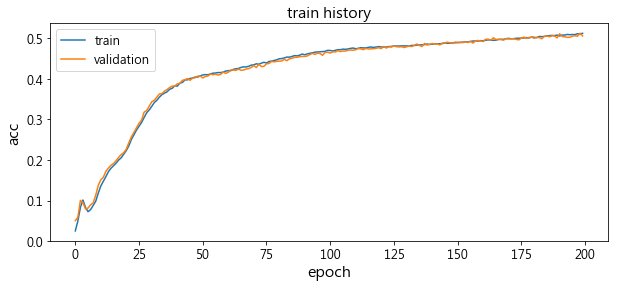

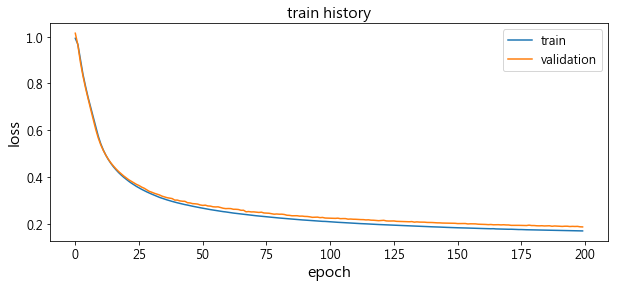

In [15]:
def show_train_history(train_history, train, validation):
    fig, ax = plt.subplots(figsize = (10, 4))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('train history', fontsize = 15)
    plt.xlabel('epoch', fontsize = 15)
    plt.ylabel(train, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 12)
    plt.legend(['train', 'validation'], fontsize = 12)
    plt.show()
    
# loss function 的變化    
show_train_history(train_history, 'acc', 'val_acc')

# accuracy 的變化
show_train_history(train_history, 'loss', 'val_loss')

#### 六、使用驗證資料辨認閥值(threshold)

In [16]:
valid_x_predictions = LSTM_autoencoder.predict(X_valid_scaled)

mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis = 1)

error_df = pd.DataFrame({'True_class': y_valid, 'Reconstruction_error': mse})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)
print('error_df[:10]:')
print(error_df[:10])
print('------------------------------------------------------------------------------')
print('precision_rt[:10]:')
print(precision_rt[:10])
print('------------------------------------------------------------------------------')
print('recall_rt[:10]:')
print(recall_rt[:10])
print('------------------------------------------------------------------------------')
print('threshold_rt[:10]:')
print(threshold_rt[:10])
print('------------------------------------------------------------------------------')

error_df[:10]:
   Reconstruction_error  True_class
0              0.089183         0.0
1              0.190569         0.0
2              0.090584         0.0
3              0.077505         0.0
4              0.071330         0.0
5              0.074564         1.0
6              0.097253         0.0
7              0.237446         0.0
8              0.115379         0.0
9              0.196125         0.0
------------------------------------------------------------------------------
precision_rt[:10]:
[0.01346672 0.01308699 0.01309203 0.01309707 0.01310212 0.01310717
 0.01311223 0.01311728 0.01312235 0.01312741]
------------------------------------------------------------------------------
recall_rt[:10]:
[1.         0.97142857 0.97142857 0.97142857 0.97142857 0.97142857
 0.97142857 0.97142857 0.97142857 0.97142857]
------------------------------------------------------------------------------
threshold_rt[:10]:
[0.06106667 0.06121396 0.06126478 0.0612955  0.0613778  0.06138303
 0.06

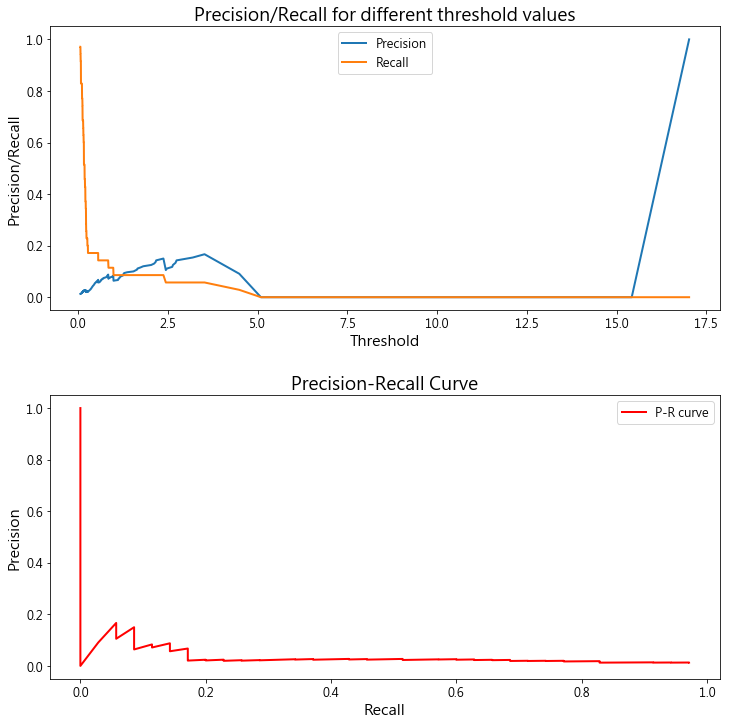

In [17]:
fig, axes = plt.subplots(2, 1, figsize = (12, 12))
plt.subplots_adjust(hspace = 0.3)

axes[0].plot(threshold_rt, precision_rt[1:], label = "Precision", linewidth = 2)
axes[0].plot(threshold_rt, recall_rt[1:], label = "Recall", linewidth = 2)
axes[0].set_title('Precision/Recall for different threshold values', fontsize = 18)
axes[0].set_xlabel('Threshold', fontsize = 15)
axes[0].set_ylabel('Precision/Recall', fontsize = 15)
axes[0].tick_params(axis = 'both', labelsize = 12)
axes[0].legend(fontsize = 12)

axes[1].plot(recall_rt[1:], precision_rt[1:], label = "P-R curve", linewidth = 2, color = 'red')
axes[1].set_title("Precision-Recall Curve", fontsize = 18)
axes[1].set_xlabel('Recall', fontsize = 15)
axes[1].set_ylabel('Precision', fontsize = 15)
axes[1].tick_params(axis = 'both', labelsize = 12)
axes[1].legend(fontsize = 12)

#### 七、使用測試資料進行分類

   index  Reconstruction_error  True_class
0      0              0.217208         0.0
1      1              0.104600         0.0
2      2              0.101634         0.0
3      3              0.608663         0.0
4      4              0.298739         0.0
5      5              0.056106         0.0
6      6              0.852949         0.0
7      7              0.152390         0.0
8      8              0.133785         0.0
9      9              0.167940         0.0
------------------------------------------------------------------------------
y=0 :
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653],
           dtype='int64', length=3600)
------------------------------------------------------------------------------
y=1 :
Int64Index([  27,   58,   77,  111,  132,  194,  229,  283,  313,  336,  410,
             563,  565,  572,  626,  647,  716,  748,  761,  765, 1013, 1051,
 

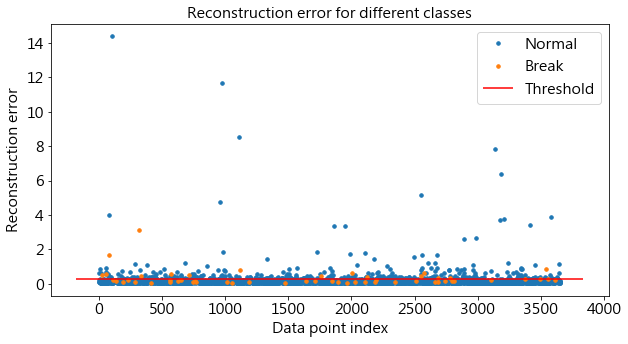

In [18]:
test_x_predictions = LSTM_autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis = 1)

error_df_test = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

error_df_test = error_df_test.reset_index()

print(error_df_test.iloc[:10])
print('------------------------------------------------------------------------------')

threshold_fixed = 0.3

groups = error_df_test.groupby('True_class')

print('y=0 :')
print(groups.groups[0])
print('------------------------------------------------------------------------------')
print('y=1 :')
print(groups.groups[1])
print('------------------------------------------------------------------------------')

fig, ax = plt.subplots(figsize = (10, 5))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '',
            label = "Break" if name == 1 else "Normal")

# zorder: 設置疊加順序
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors = "r", 
          zorder = 100, label = 'Threshold')

plt.title("Reconstruction error for different classes", fontsize = 15)
plt.ylabel("Reconstruction error", fontsize = 15)
plt.xlabel("Data point index", fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 15)
ax.legend(fontsize = 15)

#### 八、顯示混淆矩陣(confusion matrix)

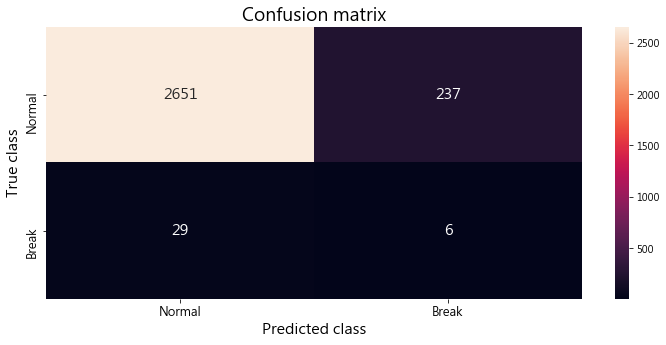

In [19]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

fig, ax = plt.subplots(figsize = (12, 5))
sns.heatmap(conf_matrix, xticklabels = ["Normal","Break"], yticklabels = ["Normal","Break"],
            fmt = "d", annot = True, annot_kws={"size": 15});
plt.title("Confusion matrix", fontsize = 18)
plt.ylabel('True class', fontsize = 15)
plt.xlabel('Predicted class', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)

#### 九、顯示 AUC 和 ROC 曲線

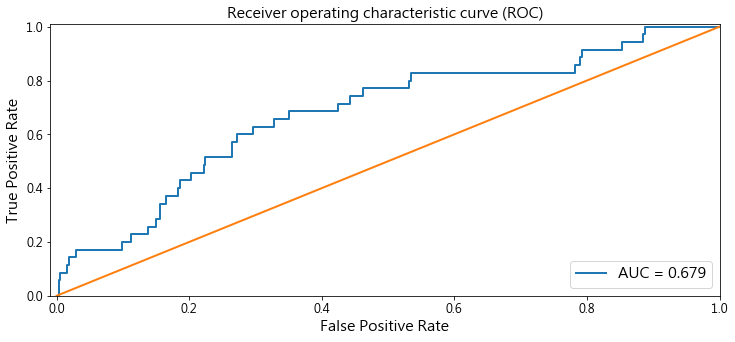

In [20]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, 
                                                      error_df.Reconstruction_error)
# 計算 AUC 值
roc_auc = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(false_pos_rate, true_pos_rate, linewidth = 2, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0, 1], [0, 1], linewidth = 2)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc = 'lower right', fontsize = 15)
plt.title('Receiver operating characteristic curve (ROC)', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

**References:**

- [Dataset: Rare Event Classification in Multivariate Time Series](https://arxiv.org/abs/1809.10717)


- [LSTM Autoencoder for Extreme Rare Event Classification in Keras](https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb)


- [Step-by-step understanding LSTM Autoencoder layers](https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb)